In [21]:
import jax 
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap
import jax.scipy as jsp 

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData

import zodiax as zx
import equinox as eqx

import pyoifits as oifits

from functools import partial
import matplotlib.pyplot as plt


In [2]:
fname = "NuHor_F480M.oifits"
ddir = "../data/"

data = oifits.open(ddir+fname)

data.verify('silentfix')


oidata = OIData(data)

In [3]:
true_values = [150., 150., 5e-4] # ra, dec, planet flux
binary = BinaryModelCartesian(true_values[0], true_values[1], true_values[2])

cvis_sim = binary.model(oidata.u, oidata.v, oidata.wavel)

# fill out a new oidata model with simulated values
sim_data = {'u': oidata.u,
            'v': oidata.v,
            'wavel': oidata.wavel,
            'vis': oidata.to_vis(cvis_sim),
            'd_vis': oidata.d_vis,
            'phi': oidata.to_phases(cvis_sim),
            'd_phi': oidata.d_phi,
            'i_cps1': oidata.i_cps1,
            'i_cps2': oidata.i_cps2,
            'i_cps3': oidata.i_cps3,
            'v2_flag': oidata.v2_flag,
            'cp_flag': oidata.cp_flag}

oidata_sim = OIData(sim_data)

In [23]:
def loglike(data_obj, model_class, params, values):

    param_dict = dict(zip(params, values))

    model_data = data_obj.model(model_class(**param_dict))
    data, errors = data_obj.flatten_data()

    return -0.5*np.sum((data - model_data)**2/errors**2)

@partial(jit, static_argnames=("model_class"))
def likelihood_grid(data_obj, model_class, samples_dict):
    # Louis suggested syntax for nice vmap over grids 
    
    params = list(samples_dict.keys())
    samples = samples_dict.values()
    vals = np.array(np.meshgrid(*samples))
    vals_vec = vals.reshape((len(vals), -1)).T
    
    fn = vmap(lambda values: loglike(data_obj,model_class,params,values))

    return fn(vals_vec).reshape(vals.shape[1:]) # check the shapes output here

In [24]:
params = ["dra", "ddec", "flux"]

loglike(oidata_sim,BinaryModelCartesian,params,true_values) # once to jit

Array(-0., dtype=float64)

In [25]:
%%timeit 
loglike(oidata_sim,BinaryModelCartesian,params,true_values)

588 µs ± 6.71 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [27]:
samples_dict = {
    "dra":  np.linspace(600., -600., 100), # left is more RA 
    "ddec": np.linspace(-600., 600., 100), # up is more dec
    "flux": 10**np.linspace(-6, -1, 100)}

loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict) # calculate once to jit

In [28]:
%%timeit
loglike_im = likelihood_grid(oidata_sim, BinaryModelCartesian, samples_dict)

598 ms ± 22.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


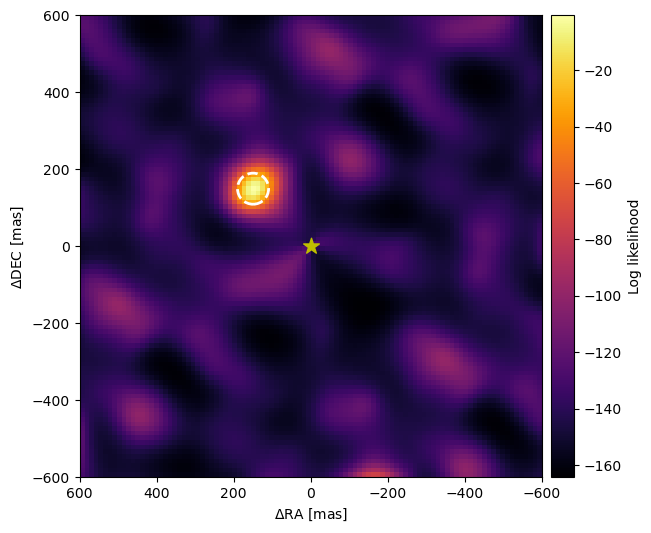

In [29]:
plt.figure(figsize=(12,6))

plt.imshow(loglike_im.max(axis=2).T, cmap="inferno",aspect="equal",
           extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()]) # this took me far too long to get the sign right for
plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
plt.scatter(0,0,s=140,c='y',marker='*')

plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')

dra_inp, ddec_inp = true_values[0], true_values[1]
plt.scatter(dra_inp,ddec_inp, 
           s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis() # up is more Dec
